## Import TensorFlow and other libraries

In [574]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, ZeroPadding2D, UpSampling2D

from keras.models import Model
from keras import backend as K

from PIL import Image, ImageDraw
from random import seed
from random import random, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import random
import os

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [575]:
print('Tensorflow Version : {}'.format(tf.__version__))
tf.random.set_seed(1300)

Tensorflow Version : 2.9.1


In [576]:
saveDir='Disk-Hole_Validation/'

In [577]:
generate_data=False
Hole_in_Training=True
weighted_pixel_loss=True
latent_dim=1
alpha_w=1
h1=5
h2=20

## Load the dataset

### Generate Disk Image DataSet


In [578]:
def loadImages(path):
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        with open(os.path.join(path, image), 'rb') as i:
            img = Image.open(i)
            loadedImages.append(np.array(img))
    return loadedImages

if generate_data:
    
        w, h = 64, 64 # Image Size

        #generate data for training

        num_images_train=20000
        radius_train=[]
        x_train =[]
        for i in range(num_images_train):
            value = uniform(0.1, 0.999)
            eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
            eX=round(eX,2)
            eY=eX
            radius_train.append(eX/2)    
            shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
            image = Image.new('L', (w, h), 'black')
            draw = ImageDraw.Draw(image)
            draw.ellipse(shape, fill = 'white', outline ='black')
            img_array=np.asarray(image)
            x_train.append(img_array)
            #image.save('disk_data/disk_data_train/disk'+str(i)+'.png')
        
        x_train = np.array(x_train)
        np.save('disk_data/disk_data_train/train.npy', x_train)
        df_train=pd.DataFrame(radius_train)
        df_train.to_csv('disk_data/radius_train.csv')

        #generate data for testing 

        num_images_test=2000
        radius_test=[]
        x_test= []
        for i in range(num_images_test):
            value = uniform(0.1, 0.999)
            eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
            eX=round(eX,2)
            eY=eX
            radius_test.append(eX/2)    
            shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
            image = Image.new('L', (w, h), 'black')
            draw = ImageDraw.Draw(image)
            draw.ellipse(shape, fill = 'white', outline ='black')
            img_array=np.asarray(image)
            x_test.append(img_array)
            #image.save('disk_data/disk_data_test/disk'+str(i)+'.png')

        x_test = np.array(x_test)
        np.save('disk_data/disk_data_test/test.npy', x_test)
        x_test1 = x_test
        df_test=pd.DataFrame(radius_test)
        df_test.to_csv('disk_data/radius_test.csv')
else:
    
    df_train=pd.read_csv('disk_data/radius_train.csv')
    df_test= pd.read_csv('disk_data/radius_test.csv')
    radius_train=df_train['0'].values
    radius_test=df_test['0'].values
    x_train=np.load('disk_data/disk_data_train/train.npy')
    x_test= np.load('disk_data/disk_data_test/test.npy')   
    w=x_train.shape[1]
    h=x_train.shape[2]

In [579]:
x_train.shape

(20000, 64, 64)

In [580]:
x_train[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Distribution Test and Train Data

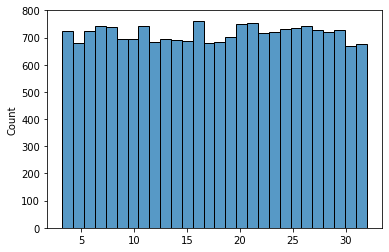

In [581]:
sns.histplot(data=radius_train)
#sns.histplot(data=radius_test)
#sns.histplot(data=r_train_h1_5)
plt.show()

### Guassian Blurring

In [582]:
# Blurring  5X5
# Blurring  5X5
x_train_blury = np.zeros((x_train.shape[0], 64, 64))
x_test_blury =  np.zeros((x_test.shape[0], 64, 64))
for i in range(x_train.shape[0]):
    x_train_blury[i] = cv2.GaussianBlur(x_train[i], (5, 5), 0)
for i in range(x_test.shape[0]):
    x_test_blury[i] =  cv2.GaussianBlur(x_test[i], (5, 5), 0)

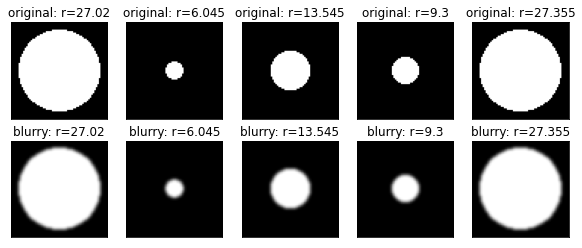

In [583]:
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_train_blury[i])
  plt.title("blurry: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [584]:

x_train_blury = x_train_blury.astype('float32') / 255.
x_test_blury  = x_test_blury.astype('float32') / 255.

print (x_train_blury.shape)
print (x_test_blury.shape)

(20000, 64, 64)
(2000, 64, 64)


# Convolutional autoencoder with bias

#### Encoder
The encoder part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (code_size).

We recommend to use activation='elu' for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), padding='same' and the following numbers of output channels: 32, 64, 128, 256.

Remember to flatten (L.Flatten()) output before adding the last dense layer!


#### Decoder
For decoder we will use so-called "transpose convolution".

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3.


Here's how "transpose convolution" works:  In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
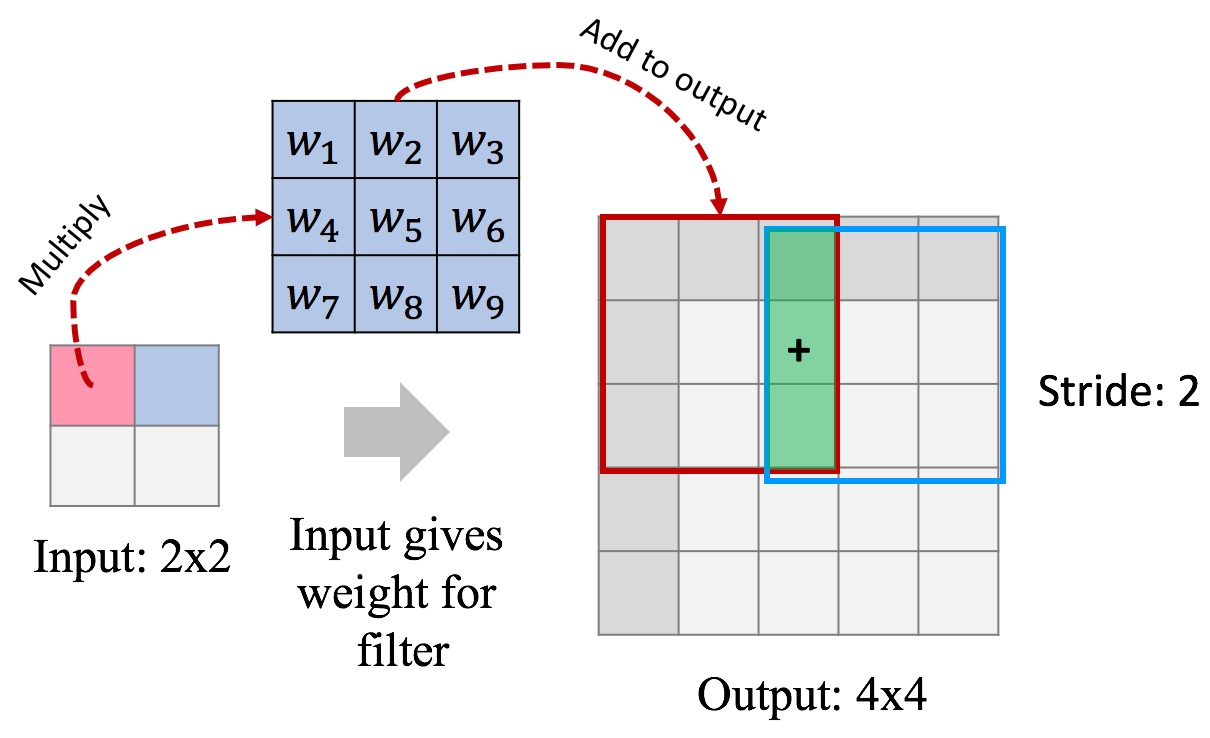

L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" L.Flatten() in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 L.Conv2DTranspose layers with the following numbers of output channels: 128, 64, 32, 3. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last L.Conv2DTranspose layer use activation=None because that is our final image.



In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

### Data Preparation for CNN Models

In [585]:
tf.keras.backend.clear_session()
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

In [586]:
num_epochs = 50
batch_size=64
verbose=1

In [587]:
# data prepration into CONV2D
x_train_blury_cnn=x_train_blury[..., np.newaxis]
x_test_blury_cnn=x_test_blury[..., np.newaxis]

In [588]:
print(' train shape dimension {}'.format(x_train_blury_cnn.shape))
print(' test shape dimension {}'.format(x_test_blury_cnn.shape))

 train shape dimension (20000, 64, 64, 1)
 test shape dimension (2000, 64, 64, 1)


In [589]:
print(' train min and max {}, {}'.format(x_train_blury_cnn.min(),x_train_blury_cnn.max()))
print(' test  min and max {}, {}'.format(x_test_blury_cnn.min(),x_test_blury_cnn.max()))

 train min and max 0.0, 1.0
 test  min and max 0.0, 1.0


### Ploting 

In [590]:
class plot_ae():
    def __init__(self, data, layer_name, encoder, decoder):
        self.data=data
        self.encoder=encoder
        self.decoder=decoder
        self.layer_name=layer_name
    
    def encode_predict(self):

        encode_model = Model(inputs= self.encoder.input,
                                  outputs=self.encoder.get_layer(self.layer_name).output)
         
        return encode_model.predict(self.data, batch_size=batch_size)
        
    def  decode_predict(self, x):
        decode_model = Model(inputs=self.decoder.input,
                                 outputs=self.decoder.output)
        return  decode_model.predict(x, batch_size=batch_size)
    
    def plot_reults(self, n, data, data_p, radius, latent, title):
        
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        for i in range(n):
            img=random.randint(0, len(radius))

            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
    
    def plot_reults_hole(self, n, data, data_p, radius, latent, title, h1, h2):
        
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        index_list=[]
        index_list1=[]
        for im in range(len(radius)):
            if radius[im]<=h2 and radius[im]>=h1:
                index_list.append(im)
            else:
                index_list1.append(im) 
                 
        for i in range(n):        
            if i <6:
                img=index_list1[random.randint(0, len(index_list1))]
            else:
                img=index_list[random.randint(0, len(index_list))]
            
            #if radius[img] >=h1 and radius[img] =<h2:
                
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
    def plot_reults_prof(self, n, data, data_p, radius, latent, title):
        
        plt.figure(figsize=(20, 6))
        plt.suptitle(title)
        for i in range(n):
            img=random.randint(0, n)
            # display original
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            t=np.arange(0,64)
            y= data[img][32]
            yp=data_p[img][32]
            ax = plt.subplot(3, n, i + 1 + n+n)
            plt.plot(t,y, label= 'Disk Profile')
            plt.plot(t,yp,label='Output Profile')
            plt.legend()
            
        plt.show()
        
    def plot_latent(self, data, latent, radius, title ):
        z=[]
        area =[]
        r=[]
        for i in range(data.shape[0]):
            z.append(latent[i][0][0][0])
            area.append((radius[i]*radius[i]*np.pi))
            r.append(radius[i])
            
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
        fig.suptitle(title)
        axes[0].set_title('inspect the latent space vs radius')
        axes[1].set_title('inspect the latent space vs area')
        axes[0].set_xlabel('z, latent space')
        axes[1].set_xlabel('z, latent space')
        axes[0].set_ylabel('disk radius')
        axes[1].set_ylabel('disk area')
        sns.scatterplot(ax=axes[0], x=z, y=r)
        sns.scatterplot(ax=axes[1], x=z, y=area)
        plt.show()
        return z, r, area
        

In [591]:

activ=LeakyReLU(alpha=0.2)


inp=Input(shape=(64, 64,1), name='en1')

weights_tensor = Input(shape=(64, 64, 1), name='weights')
true = Input(shape=(64, 64, 1), name='true')

p=ZeroPadding2D( padding=(1, 1) )(inp)
cx=Conv2D(8, (3, 3), activation=activ, strides=2, name='en2', kernel_initializer='he_normal') (p)
p=ZeroPadding2D( padding=(1, 1) )(cx)
cx=Conv2D(4, (3, 3), activation=activ, strides=2, name='en4', kernel_initializer='he_normal')(p)
p=ZeroPadding2D( padding=(1, 1) )(cx)
cx=Conv2D(4, (3, 3), activation=activ, strides=2, name='en6', kernel_initializer='he_normal') (p)
p=ZeroPadding2D( padding=(1, 1) )(cx)
cx=Conv2D(3, (3, 3), activation=activ, strides=2, name='en8', kernel_initializer='he_normal') (p)
p=ZeroPadding2D( padding=(1, 1) ) (cx)
cx=Conv2D(2, (3, 3), activation=activ, strides=2, name='en10', kernel_initializer='he_normal') (p)
p=ZeroPadding2D( padding=(1, 1) ) (cx)
cx=Conv2D(1, (3, 3), activation=activ, strides=2, name='en13', kernel_initializer='he_normal') (p)

# Instantiate encoder
encoder = Model(inp, cx, name='encoder')


idd=UpSampling2D((2,2), name='de1') (cx)
cd=Conv2DTranspose(1,  kernel_size=3,activation=activ,name='de2', padding='same',kernel_initializer='he_normal') (idd)
ud=UpSampling2D((2,2), name='de3') (cd)
cd=Conv2DTranspose(2,  kernel_size=3,activation=activ,name='de4', padding='same',kernel_initializer='he_normal') (ud)
ud=UpSampling2D((2,2), name='de5') (cd)
cd=Conv2DTranspose(3,  kernel_size=3,activation=activ,name='de6', padding='same',kernel_initializer='he_normal') (ud)
ud=UpSampling2D((2,2), name='de7') (cd)
cd=Conv2DTranspose(4,  kernel_size=3,activation=activ,name='de8', padding='same',kernel_initializer='he_normal') (ud)
ud=UpSampling2D((2,2), name='de9') (cd)
cd=Conv2DTranspose(4, kernel_size=3,activation=activ, name='de10',padding='same',kernel_initializer='he_normal') (ud)
ud=UpSampling2D((2,2), name='de11') (cd)
cd=Conv2DTranspose(8, kernel_size=3,activation=activ, name='de12', padding='same',kernel_initializer='he_normal') (ud)
cd=Conv2D(1, kernel_size=3, activation='sigmoid', padding='same', name='de13', kernel_initializer='he_normal') (cd)

decoder = Model(cx, cd, name='decoder')


autoencoder_output = decoder(encoder(inp))
autoencoder        = Model([inp,true,weights_tensor], autoencoder_output, name='AE')
autoencoder.summary()


Model: "AE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 en1 (InputLayer)               [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 1, 1, 1)      706         ['en1[0][0]']                    
                                                                                                  
 true (InputLayer)              [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 weights (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                 

## Training with whole

In [592]:
if Hole_in_Training:
    
        x_train_h=[]
        x_train_h_rad=[]
        for i in range(x_train_blury_cnn.shape[0]):
            if radius_train[i]>h2 or radius_train[i]<h1 :
                x_train_h.append(x_train_blury_cnn[i])
                x_train_h_rad.append(radius_train[i])
        x_train_h=np.array(x_train_h)
        x_train_blury_cnn = x_train_h
        radius_train= x_train_h_rad

In [593]:
print(np.max(radius_train), np.max(radius_test) )
print(np.min(radius_train), np.min(radius_test) )

31.965 31.95
3.2 3.2


In [594]:
treashhold=0.5
if weighted_pixel_loss:
    
    weight_img=[]
    for img in x_train_blury_cnn:
        nw, nb= 0, 0
        w=img.copy()
        w[w>=treashhold]=1
        w[w<treashhold]=0

        nw=np.sum(w==1) #white is one
        nb=np.sum(w==0) #black is zero
        print(nb,nw)
        w[w==1]=(nb**alpha_w)/(nb+nw) #white
        w[w==0]=nw/(nb+nw) #black
        weight_img.append(w)


    weight_img=np.array(weight_img)   
else:
    weight_img=np.ones_like(x_train_blury_cnn)

1804 2292
1804 2292
2424 1672
1968 2128
2568 1528
1444 2652
1444 2652
1444 2652
2276 1820
2276 1820
2700 1396
4064 32
1968 2128
4064 32
4064 32
2120 1976
1804 2292
1444 2652
1624 2472
1968 2128
2832 1264
2120 1976
2832 1264
4044 52
1968 2128
4044 52
1024 3072
2276 1820
2832 1264
2568 1528
1624 2472
2424 1672
1444 2652
2120 1976
2832 1264
4044 52
2568 1528
1444 2652
1968 2128
2568 1528
4044 52
1804 2292
1024 3072
2832 1264
2120 1976
4044 52
1624 2472
2120 1976
1024 3072
2120 1976
2832 1264
1444 2652
1024 3072
2832 1264
1804 2292
2424 1672
2568 1528
4044 52
1624 2472
1624 2472
1968 2128
1268 2828
2832 1264
2120 1976
4064 32
1968 2128
2424 1672
2700 1396
4064 32
1804 2292
2832 1264
1968 2128
2568 1528
1968 2128
2832 1264
2568 1528
2120 1976
1268 2828
2035 2061
4064 32
1024 3072
2424 1672
1804 2292
2700 1396
1444 2652
2568 1528
1444 2652
2120 1976
1968 2128
1804 2292
1024 3072
2276 1820
2568 1528
2120 1976
2832 1264
1804 2292
1444 2652
2276 1820
2120 1976
1624 2472
1444 2652
4044 52
1268 2

1804 2292
1268 2828
1268 2828
2568 1528
1024 3072
1624 2472
4064 32
1268 2828
1444 2652
2700 1396
1268 2828
1968 2128
1968 2128
1624 2472
1444 2652
4044 52
2568 1528
2832 1264
4044 52
1024 3072
2424 1672
2700 1396
2276 1820
4064 32
1024 3072
1444 2652
1444 2652
1804 2292
2424 1672
2120 1976
4044 52
2568 1528
1804 2292
2276 1820
1624 2472
2700 1396
1624 2472
2700 1396
1968 2128
2276 1820
2832 1264
2568 1528
2424 1672
4044 52
2276 1820
1444 2652
2424 1672
2120 1976
1804 2292
1024 3072
2832 1264
4044 52
1024 3072
2568 1528
2424 1672
2832 1264
1804 2292
2424 1672
4064 32
2120 1976
1024 3072
4044 52
2568 1528
1804 2292
2424 1672
2120 1976
1624 2472
1968 2128
2424 1672
4064 32
4044 52
4044 52
2568 1528
4044 52
2424 1672
1268 2828
1624 2472
1968 2128
1968 2128
2120 1976
1968 2128
2700 1396
4044 52
2832 1264
2832 1264
1024 3072
2832 1264
1968 2128
1624 2472
1968 2128
1268 2828
1968 2128
4044 52
2276 1820
1804 2292
1024 3072
1804 2292
1444 2652
1024 3072
1624 2472
2700 1396
2568 1528
1444 2652


2832 1264
2276 1820
2276 1820
2120 1976
2568 1528
1268 2828
4044 52
4044 52
1444 2652
2120 1976
1804 2292
1024 3072
1268 2828
1968 2128
2832 1264
2832 1264
2424 1672
4044 52
1024 3072
1804 2292
2700 1396
1268 2828
2832 1264
2424 1672
2832 1264
1024 3072
4044 52
2276 1820
4064 32
1804 2292
1804 2292
1804 2292
4044 52
2568 1528
2276 1820
2832 1264
1968 2128
1968 2128
2700 1396
1024 3072
2276 1820
2276 1820
2276 1820
1624 2472
2424 1672
2276 1820
1968 2128
4064 32
4064 32
2832 1264
2276 1820
1804 2292
2276 1820
2424 1672
2832 1264
1444 2652
2568 1528
1624 2472
1804 2292
1804 2292
2120 1976
2120 1976
2700 1396
2832 1264
2276 1820
1268 2828
1444 2652
2424 1672
1444 2652
2568 1528
1968 2128
2832 1264
2832 1264
1624 2472
2424 1672
4064 32
1968 2128
1624 2472
2568 1528
4064 32
4044 52
2700 1396
1804 2292
2700 1396
1268 2828
4064 32
1024 3072
1268 2828
2568 1528
2120 1976
2276 1820
2035 2061
1444 2652
1444 2652
2424 1672
2120 1976
1624 2472
1624 2472
1444 2652
2700 1396
2424 1672
4044 52
4044 5

2276 1820
1444 2652
1804 2292
1968 2128
1444 2652
2832 1264
2832 1264
1444 2652
4044 52
2832 1264
4044 52
1444 2652
2276 1820
4064 32
1024 3072
1804 2292
4044 52
1968 2128
2424 1672
1268 2828
1624 2472
2424 1672
2276 1820
2424 1672
4064 32
1268 2828
1968 2128
4044 52
1268 2828
2276 1820
1444 2652
1024 3072
1968 2128
1968 2128
2120 1976
4044 52
2276 1820
4044 52
2424 1672
2700 1396
2424 1672
2832 1264
1804 2292
1444 2652
2120 1976
1804 2292
1804 2292
4064 32
1444 2652
1624 2472
2424 1672
4064 32
2568 1528
2120 1976
2424 1672
1624 2472
2276 1820
2276 1820
4064 32
1804 2292
2832 1264
2700 1396
1804 2292
1624 2472
1968 2128
1804 2292
1968 2128
4064 32
1804 2292
2120 1976
2276 1820
2568 1528
1444 2652
2700 1396
1024 3072
1624 2472
1444 2652
1804 2292
2832 1264
2568 1528
1804 2292
4044 52
1624 2472
1804 2292
2424 1672
4044 52
1624 2472
2700 1396
2832 1264
1624 2472
1624 2472
2700 1396
2568 1528
2700 1396
1804 2292
1444 2652
1444 2652
2120 1976
1024 3072
1968 2128
1444 2652
2568 1528
1804 229

2120 1976
2700 1396
1268 2828
2276 1820
1968 2128
1444 2652
1968 2128
1968 2128
2639 1457
2700 1396
2568 1528
2832 1264
2700 1396
2832 1264
1444 2652
1968 2128
1024 3072
1024 3072
1804 2292
2120 1976
4064 32
1444 2652
1968 2128
1804 2292
1024 3072
2568 1528
1268 2828
2424 1672
1444 2652
1268 2828
2832 1264
1968 2128
2120 1976
2276 1820
1624 2472
1968 2128
2832 1264
2424 1672
2276 1820
1624 2472
1444 2652
2276 1820
2832 1264
1268 2828
2700 1396
2700 1396
1024 3072
1804 2292
1624 2472
1968 2128
2832 1264
1624 2472
2120 1976
2276 1820
2832 1264
1968 2128
1968 2128
1624 2472
1624 2472
1444 2652
1804 2292
2276 1820
2832 1264
1804 2292
1968 2128
1268 2828
1268 2828
1804 2292
1624 2472
1968 2128
1968 2128
2832 1264
4044 52
1804 2292
2568 1528
2424 1672
1804 2292
2276 1820
2276 1820
2700 1396
4044 52
1968 2128
2120 1976
4044 52
1268 2828
2775 1321
1968 2128
1024 3072
2568 1528
2568 1528
2832 1264
1444 2652
1024 3072
4064 32
1268 2828
1968 2128
4044 52
4044 52
1024 3072
2832 1264
1968 2128
1024

In [595]:
np.unique(weight_img[1])

array([0.4404297, 0.5595703], dtype=float32)

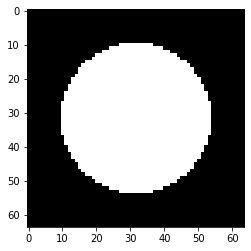

In [596]:
plt.imshow(weight_img[4])

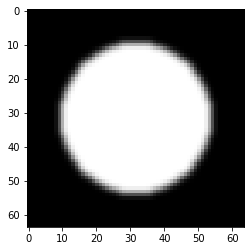

In [597]:
plt.imshow(x_train_blury_cnn[4])

In [598]:
def mmse(y_true, y_pred, sample_weight):
    
    loss= tf.reduce_mean(tf.math.multiply(tf.math.squared_difference(y_true, y_pred),sample_weight))
    
    return loss

In [599]:
opti=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False )

#autoencoder.add_loss(mmse(true, autoencoder_output, weights_tensor))

autoencoder.add_loss( mmse( true, cd, weights_tensor ) )

autoencoder.compile(optimizer=opti, loss=None)

es = EarlyStopping(monitor="val_loss", mode="min", verbose=verbose, patience=3)
mc = ModelCheckpoint( "model", monitor="val_loss", mode="max", verbose=verbose, save_best_only=True)



histh1_5=autoencoder.fit([x_train_blury_cnn,x_train_blury_cnn, weight_img], x_train_blury_cnn,
                epochs=num_epochs,
                batch_size=batch_size,
                validation_split=0.2, callbacks=[es, mc], verbose=verbose)

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 0.0476
Epoch 1: val_loss improved from -inf to 0.01336, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


121/121 [==============================] - 5s 34ms/step - loss: 0.0476 - val_loss: 0.0134
Epoch 2/50
118/121 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 2: val_loss did not improve from 0.01336
121/121 [==============================] - 2s 12ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 3/50
119/121 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 3: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/50
120/121 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 4: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/50
120/121 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 5: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/50
121/121 [==============================] - 

121/121 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 9.8250e-04
Epoch 40/50
120/121 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 40: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 9.8096e-04
Epoch 41/50
120/121 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 41: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 9.7804e-04
Epoch 42/50
121/121 [==============================] - ETA: 0s - loss: 0.0010
Epoch 42: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 9.7894e-04
Epoch 43/50
121/121 [==============================] - ETA: 0s - loss: 0.0010
Epoch 43: val_loss did not improve from 0.01336
121/121 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 9.7684e-04
Epoch 44/50
119/121 [=====

In [600]:
autoencoder_final=Model(inputs=inp, outputs=autoencoder_output, name='AE-test')

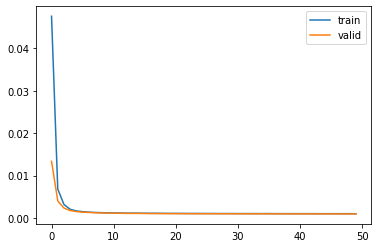

In [601]:
# Capturing learning history per epoch
hist = pd.DataFrame(histh1_5.history)
hist["epoch"] = histh1_5.epoch

# Plotting accuracy at different epochs
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(("train", "valid"), loc=0)

In [602]:
result_train_h=plot_ae(data=x_train_blury_cnn, layer_name='en13', encoder=encoder, decoder=decoder)
result_test_h =plot_ae(data=x_test_blury_cnn,  layer_name='en13', encoder=encoder, decoder=decoder )

In [603]:
encoded_imgs_train_h= result_train_h.encode_predict()
decoded_imgs_train_h= result_train_h.decode_predict(encoded_imgs_train_h)
decoded_imgs_train_h= decoded_imgs_train_h[:, :, :,0]

151/151 [==============================] - 0s 2ms/step


In [604]:
encoded_imgs_test_h=result_test_h.encode_predict()
decoded_imgs_test_h=result_test_h.decode_predict(encoded_imgs_test_h)
decoded_imgs_test_h=  decoded_imgs_test_h[:, :, :,0]

32/32 [==============================] - 0s 2ms/step


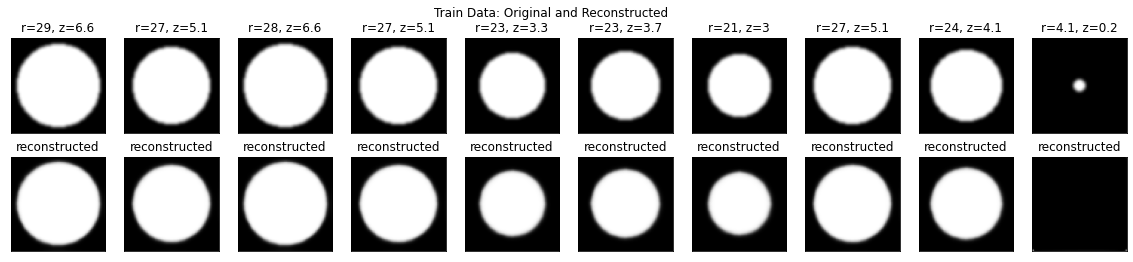

In [605]:
result_train_h.plot_reults(n=10, data=x_train_blury_cnn, data_p=decoded_imgs_train_h, radius=radius_train, 
                         latent=encoded_imgs_train_h, title='Train Data: Original and Reconstructed')

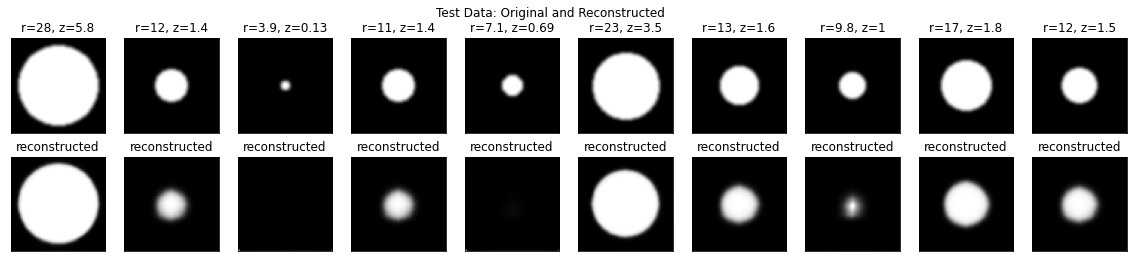

In [606]:
result_test_h.plot_reults(n=10, data=x_test_blury_cnn, data_p=decoded_imgs_test_h, radius=radius_test, 
                         latent=encoded_imgs_test_h, title='Test Data: Original and Reconstructed')

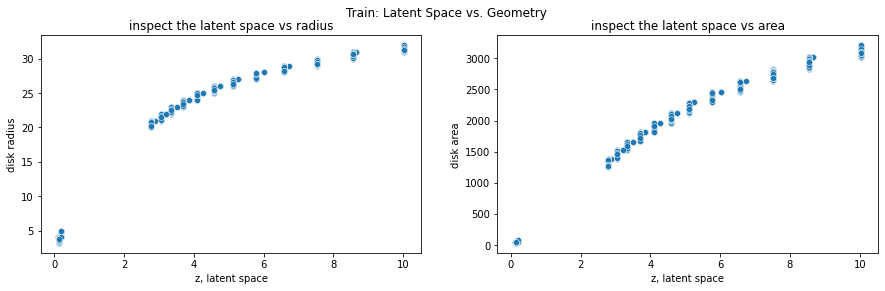

In [607]:
z_train_h1_5, r_train_h1_5, area_train_h1_5= result_train_h.plot_latent(data=x_train_blury_cnn, latent=encoded_imgs_train_h, radius=radius_train, 
                           title='Train: Latent Space vs. Geometry' )

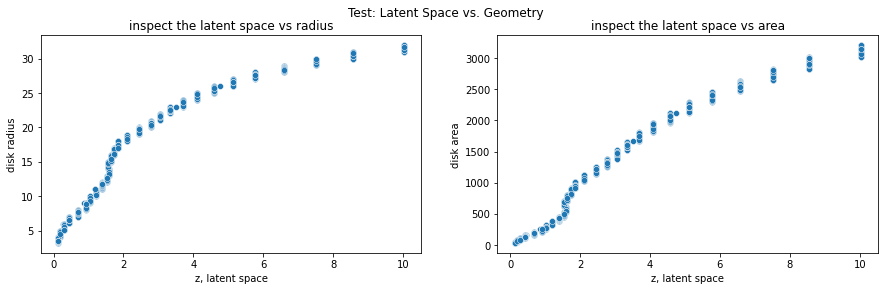

In [608]:
z_test_h1_5, r_test_h1_5, area_test_h1_5= result_test_h.plot_latent(data=x_test_blury_cnn, latent=encoded_imgs_test_h, 
                           radius=radius_test, title='Test: Latent Space vs. Geometry' )

In [609]:
latent_df=pd.DataFrame({'z':z_test_h1_5, 
                     'r': r_test_h1_5, 
                     'area':area_test_h1_5})

In [610]:
#autoencoder.save('Saved_Model\DISCK_Weighted_Alpha_1')
#hist.to_csv('Saved_Model\DISCK_Weighted_Alpha_1/hist_disk_Weighted_alpha_1.csv')
latent_df.to_csv('validation_weight_alpha_hole\latent_disk_Hole_5_20_Weighted.csv')

In [611]:
result_test= autoencoder_final.predict(x_test_blury_cnn)
result_train=autoencoder_final.predict(x_train_blury_cnn)

302/302 [==============================] - 1s 3ms/step


In [612]:
x_train_blury_cnn.shape

(9640, 64, 64, 1)

In [613]:
mse=tf.keras.losses.MeanSquaredError()
n_images = x_train_blury_cnn.shape[0]
mse_per = []
weighted_mse_per = []
for img in range(n_images):
    mse_per.append(mse(x_train_blury_cnn[img:img+1,:,:,:], result_train[img:img+1,:,:,:]).numpy())
    weighted_mse_per.append(mmse(x_train_blury_cnn[img:img+1,:,:,:], result_train[img:img+1,:,:,:], weight_img[img:img+1]).numpy())

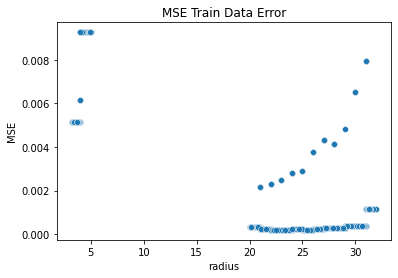

In [614]:
sns.scatterplot(x=radius_train, y=mse_per)
plt.title('MSE Train Data Error')
plt.xlabel('radius')
plt.ylabel('MSE')
plt.show()

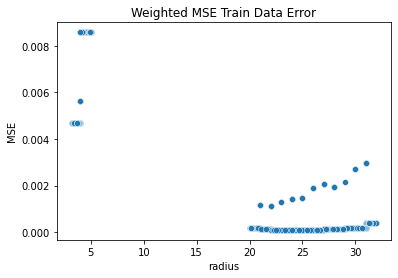

In [615]:
sns.scatterplot(x=radius_train, y=weighted_mse_per)
plt.title('Weighted MSE Train Data Error')
plt.xlabel('radius')
plt.ylabel('MSE')
plt.show()

In [616]:
df0=pd.read_csv('validation_weight_alpha_hole\latent_disk_non_Weighted.csv')
df1=pd.read_csv('validation_weight_alpha_hole\latent_disk_Weighted.csv')
df2=pd.read_csv('validation_weight_alpha_hole\latent_disk_Hole_10_15.csv')
df3=pd.read_csv('validation_weight_alpha_hole\latent_disk_Hole_10_15_Weighted.csv')
#df10=pd.read_csv('validation_weight_alpha_hole\latent_disk_Weighted_alpha_10.csv')
#df00=pd.read_csv('validation_weight_alpha_hole\latent_disk_alpha_10.csv')

<AxesSubplot:label='Pixelwise-Weighted MSE', xlabel='z', ylabel='r'>

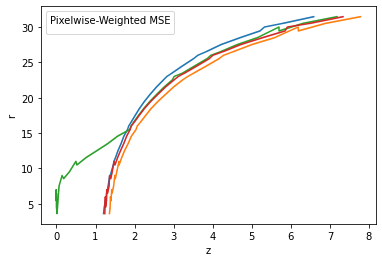

In [617]:
new_labels = ['Standard MSE', 'Pixelwise-Weighted MSE']

s0=sns.lineplot(data=df0, x='z', y='r', legend='auto')
s0.set_label(new_labels[0])
s0.legend(title=new_labels[0])

s1=sns.lineplot(data=df1, x='z', y='r', legend='auto')
s1.set_label(new_labels[1])
s1.legend(title=new_labels[1])

sns.lineplot(data=df2, x='z', y='r')
sns.lineplot(data=df3, x='z', y='r')
#sns.lineplot(data=df10, x='z', y='area')
#sns.lineplot(data=df00, x='z', y='area')
